# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex, u_diode_data_to_df
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis
from src.modeling.sec_quench import *
from src.utils.dataset_utils import *

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')
#%matplotlib widget

In [3]:
%matplotlib inline

# Define Paths

In [4]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / '20220707_data'
simulation_path = file_path / '20220707_simulation'

# Read the (clean) MP3 file

In [5]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

4763

# Select events to analyze

In [6]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

896 4379


In [7]:
# Add information, whether download was successfull
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")
mp3_fpa_df_period_merged = mp3_fpa_df_period.merge(df_acquisition , left_on=['Circuit Name', 'timestamp_fgc'], right_on=['Circuit Name', 'timestamp_fgc'], how="left")
df_to_analyze = mp3_fpa_df_period_merged[mp3_fpa_df_period_merged['VoltageNQPS.*U_DIODE']==1]
len(df_to_analyze)

668

# Analyze all events

In [8]:
def u_diode_simulation_to_df(data_sim, circuit_name):
    df_simulation_all = pd.concat(data_sim, axis=1) 
    sorted_columns = [f"V(0v_magf{i})"for i in range(1, len(df_simulation_all.filter(regex="0v_magf").columns)+1)]
    df_simulation = df_simulation_all[sorted_columns]
    
    #simulation numbering is sorted by #Electric_circuit
    df_metadata = MappingMetadata.read_layout_details("RB")
    df_metadata = df_metadata[df_metadata.Circuit ==circuit_name].sort_values("#Electric_circuit") 

    magnet_names = df_metadata.Magnet.apply(lambda x: x + ":U_DIODE_RB" ).values
    df_simulation.columns = magnet_names
    return df_simulation

In [9]:
def drop_quenched_magnets(df, all_quenched_magnets, quench_times, max_time):
    quench_within_frame = ["MB." + all_quenched_magnets[i] + ":U_DIODE_RB" for i, t in enumerate(quench_times) if (t < max_time)]
    df = df.drop(columns=quench_within_frame)
    return df

In [11]:
def get_u_diode_data_alignment_timestamps(df, th=-0.5, dth=-0.5, medfilt_size=101):
    df_filt = df.rolling(medfilt_size, center=True).median()
    df_diff_filt = df_filt.diff()
    alignment_timestamps = [df_diff_filt.index.values[np.where((df_filt[c] < th)&(df_diff_filt[c] < dth))[0][0]] for c in df_diff_filt.columns]
    return alignment_timestamps
    
def get_u_diode_simulation_alignment_timestamps(df, th=0, dth=-0.2, medfilt_size=101):
    df_diff = df.diff()
    alignment_timestamps = [df_diff.index.values[np.where(df_diff[c] < dth)[0][0]] for c in df_diff.columns]
    return alignment_timestamps

def align_u_diode_data_to_simulation(df_data, df_sim, shift_th=20):
    #align_ts = get_u_diode_simulation_alignment_timestamps(df_sim)
    offset_ts = get_u_diode_data_alignment_timestamps(df_data)
    
    for i, c in enumerate(df_data.columns):
        # index, where time is closest to alignment ts
        zero_index = np.argmin(abs(df_data.index.values - t_first_extraction))
        
        # index, where time is closest to offset_ts
        delta_index = np.argmin(abs(df_data.index.values - offset_ts[i]))
        
        shift_index =  zero_index - delta_index 
        if abs(shift_index) > shift_th:
            df_data[c] = df_data[c].shift(shift_index)
    return df_data.dropna()

In [12]:
def interp(df, new_index):
    """Return a new DataFrame with all columns values interpolated
    to the new_index values."""
    df_out = pd.DataFrame(index=new_index)
    df_out.index.name = df.index.name

    for colname, col in df.iteritems():
        df_out[colname] = np.interp(new_index, df.index, col)

    return df_out

In [13]:
def data_to_xarray(df_data, df_simulation, event_identifier):
    # https://rabernat.github.io/research_computing_2018/xarray.html#:~:text=1%3A%20Xarray%20Fundamentals-,Xarray%20data%20structures,potentially%20share%20the%20same%20coordinates
    n_magnets=154
    coords = {"event":[event_identifier],
              "type":["data", "simulation"], 
              "el_position": np.arange(n_magnets), 
              "time": df_data_cut.index}

    ds = xr.DataArray(data=np.expand_dims(np.array((df_data.values.T, df_simulation.values.T)), axis=0), coords=coords)
    return ds

In [14]:
fpa_identifier = "RB_RB.A34_1616917289180000000"    
circuit_name = fpa_identifier.split("_")[1]
timestamp_fgc = int(fpa_identifier.split("_")[2])

mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & 
                               (mp3_fpa_df['Circuit Name'] == circuit_name)]
all_quenched_magnets = mp3_fpa_df_subset.Position.values
quench_times = mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3
        
# load data
data_dir = data_path / (fpa_identifier + ".hdf5")
data = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
df_data = u_diode_data_to_df(data, len_data=len(data[0]))

# load simulation 
simulation_dir = simulation_path / (fpa_identifier + ".hdf")
data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
df_sim = u_diode_simulation_to_df(data_sim, circuit_name=circuit_name)

# save magnet order for later useage
magnet_list=df_sim.columns
                        
# drop quenched magnet
max_time = df_data.index.max()
df_data_noq = drop_quenched_magnets(df_data, all_quenched_magnets, quench_times, max_time)
df_sim_noq = drop_quenched_magnets(df_sim, all_quenched_magnets, quench_times, max_time)

# sometimes only noise is stored, mean must be in windwo -1, -10
df_data_noq = df_data_noq.drop(df_data_noq.columns[~(-1>df_data_noq.mean()) & (-10<df_data_noq.mean())], axis=1)

# align 
t_first_extraction = min(float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000, 
                         float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000)
df_data_aligned = align_u_diode_data_to_simulation(df_data_noq.copy(), t_first_extraction)

# cut out time frame to analyze, [-0.25, 1] is 1336 samples
time_frame = [-0.25, 1]
df_data_cut = df_data_aligned[(time_frame[0] <= df_data_aligned.index) & (time_frame[1] >= df_data_aligned.index)]

# adjust simulation length to data 
df_sim_noq_resampled = interp(df_sim_noq, df_data_cut.index)

# add quenched magnets again for continuity
dropped_columns_data = magnet_list[~magnet_list.isin(df_data_cut.columns)]
dropped_columns_simulation = magnet_list[~magnet_list.isin(df_sim_noq_resampled.columns)]
df_data_cut[dropped_columns_data] = np.nan
df_sim_noq_resampled[dropped_columns_simulation] = np.nan
# bring into electrical order again
df_data_cut = df_data_cut[magnet_list]
df_sim_noq_resampled = df_sim_noq_resampled[magnet_list]

# add data and simulation
xr_dataset = data_to_xarray(df_data=df_data_cut, df_simulation=df_sim_noq_resampled, event_identifier=fpa_identifier)
xr_dataset

<xarray.DataArray (event: 1, type: 2, el_position: 154, time: 1336)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [ 9.66556550e-01,  9.41919300e-01,  9.55659870e-01, ...,
          -1.02658200e+01, -1.02643990e+01, -1.02643990e+01],
         [ 9.68925500e-01,  9.53290940e-01,  9.58976750e-01, ...,
          -1.03288350e+01, -1.03278880e+01, -1.03274140e+01],
         ...,
         [ 9.69400400e-01,  9.64662550e-01,  9.59922800e-01, ...,
          -1.02857190e+01, -1.02852460e+01, -1.02852460e+01],
         [ 9.69873400e-01,  9.63239670e-01,  9.56607800e-01, ...,
          -1.03032490e+01, -1.03023020e+01, -1.03018280e+01],
         [ 9.59449770e-01,  9.59449770e-01,  9.63714600e-01, ...,
          -1.03278880e+01, -1.03288350e+01, -1.03312030e+01]],

        [[-1.49894047e-04, -1.49607486e-04, -1.49320925e-04, ...,
          -1.04225003e+01, -1.04224059e+01, -1.04223104e+01],
         [-1.50007285e-04, -1.49720748e-04, -1.49434210e-04, ...,
          -1.04225368e+01, -1.04224419e+01, -1.04223464e+01],
         [-1.49899532e-04, -1.49612970e-04, -1.49326408e-04, ...,
          -1.04225008e+01, -1.04224059e+01, -1.04223114e+01],
         ...,
         [-1.50081161e-04, -1.49794649e-04, -1.49508137e-04, ...,
          -1.04225053e+01, -1.04224109e+01, -1.04223164e+01],
         [-1.50064931e-04, -1.49778414e-04, -1.49491897e-04, ...,
          -1.04225003e+01, -1.04224059e+01, -1.04223114e+01],
         [-1.50075601e-04, -1.49789080e-04, -1.49502560e-04, ...,
          -1.04225038e+01, -1.04224089e+01, -1.04223144e+01]]]])
Coordinates:
  * event        (event) <U29 'RB_RB.A34_1616917289180000000'
  * type         (type) <U10 'data' 'simulation'
  * el_position  (el_position) int64 0 1 2 3 4 5 6 ... 148 149 150 151 152 153
  * time         (time) float64 -0.2497 -0.2487 -0.2478 ... 0.9981 0.999 0.9999

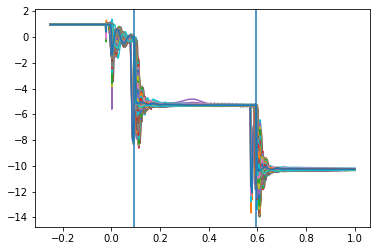

In [21]:
df_data_cut.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

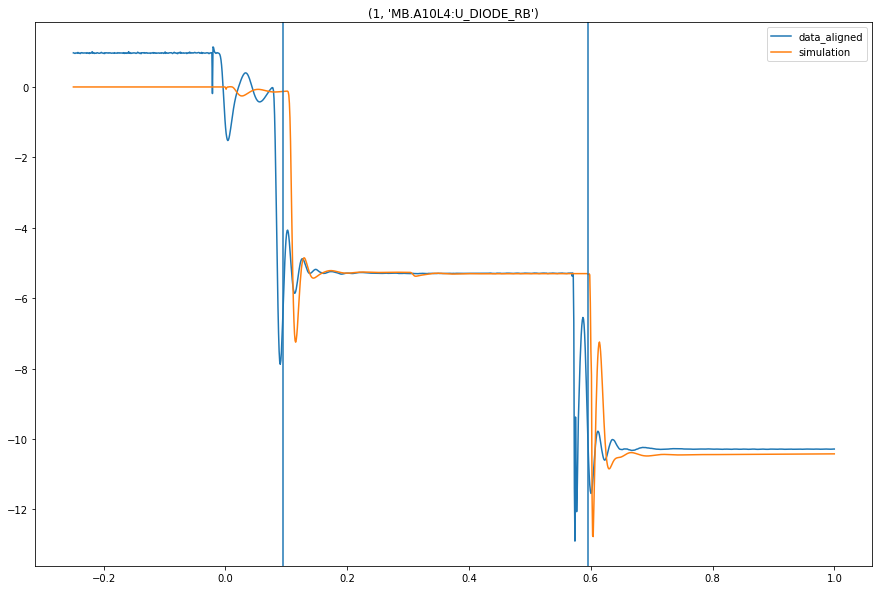

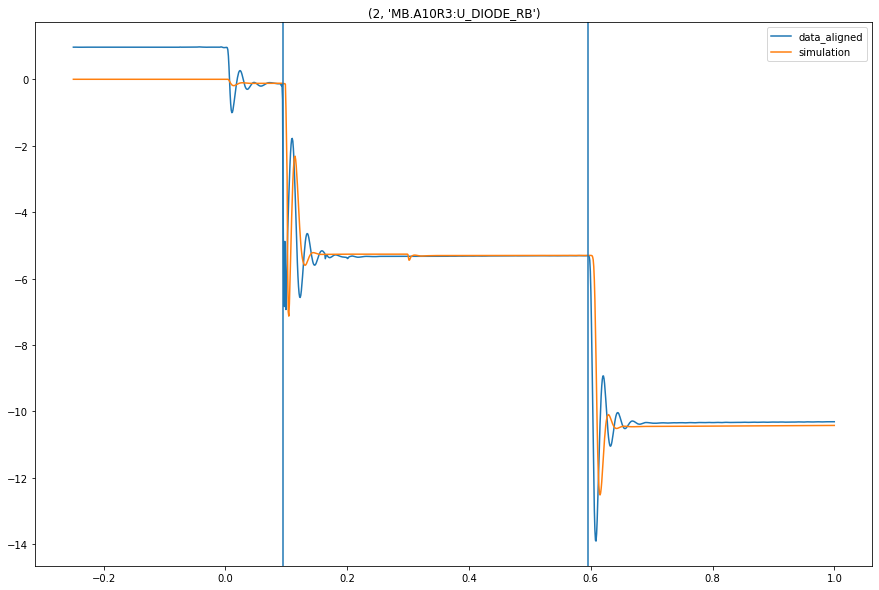

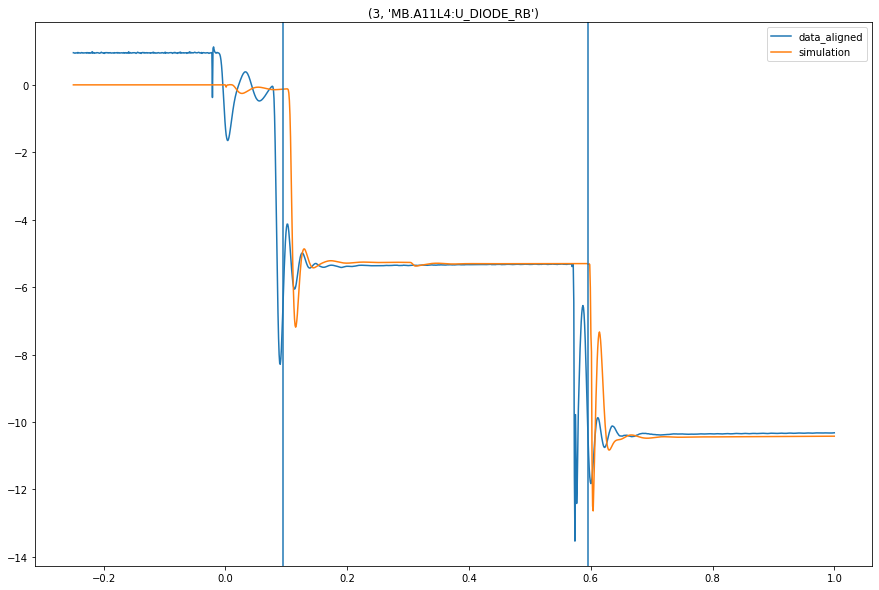

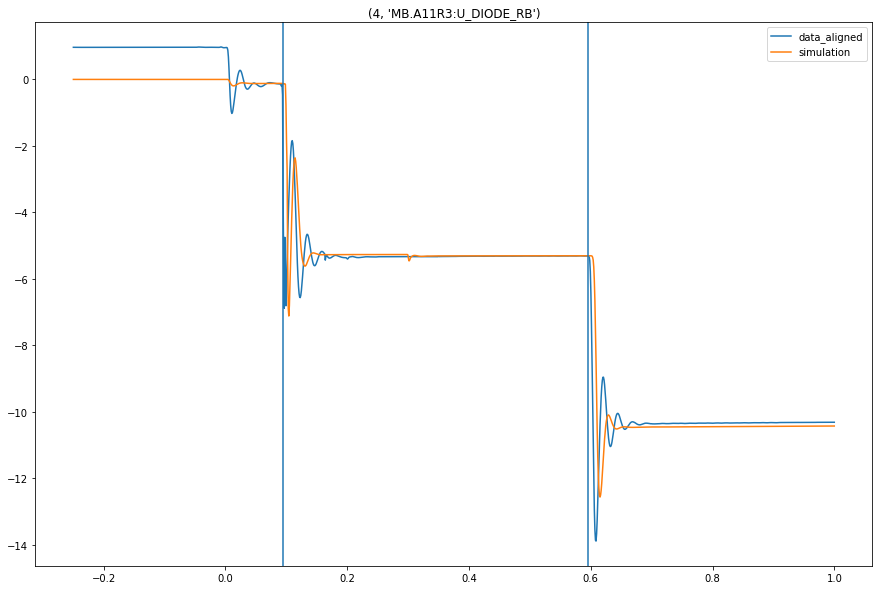

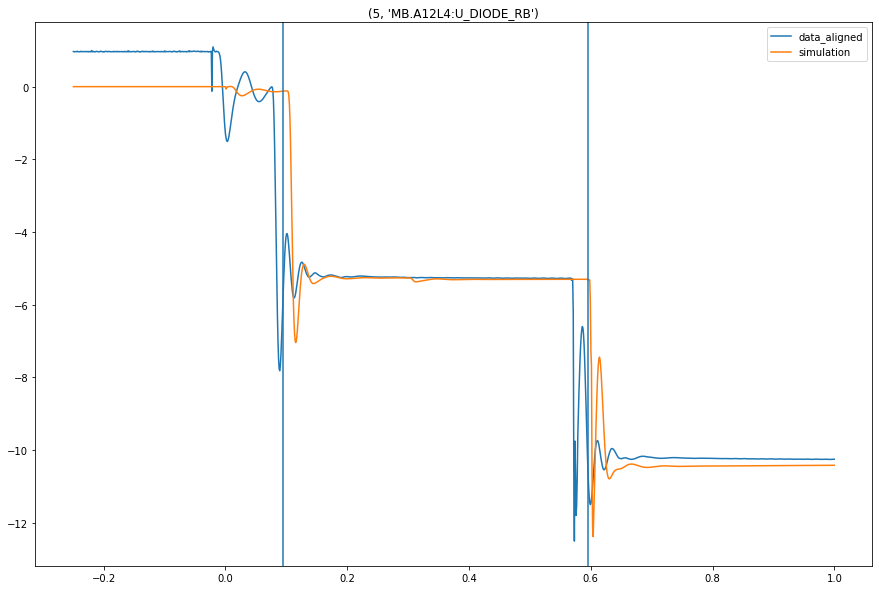

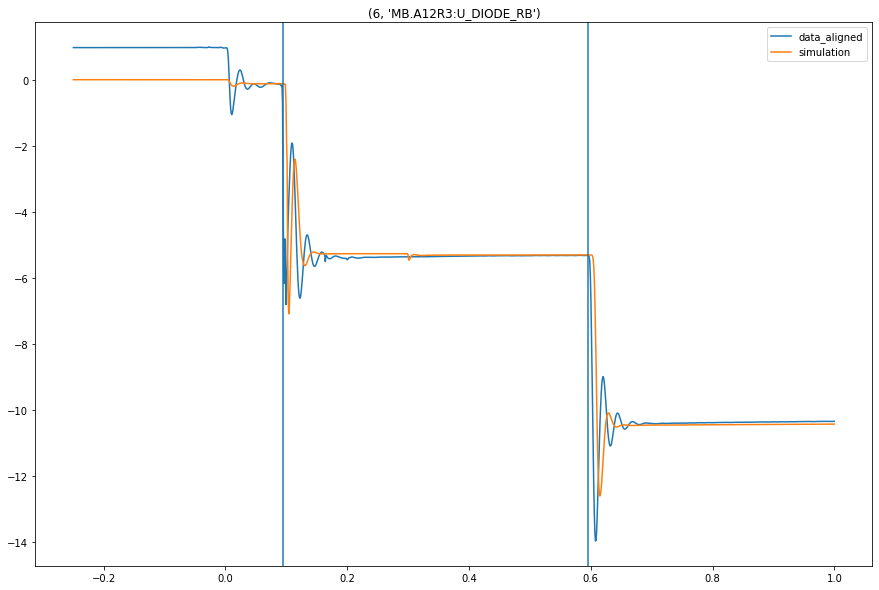

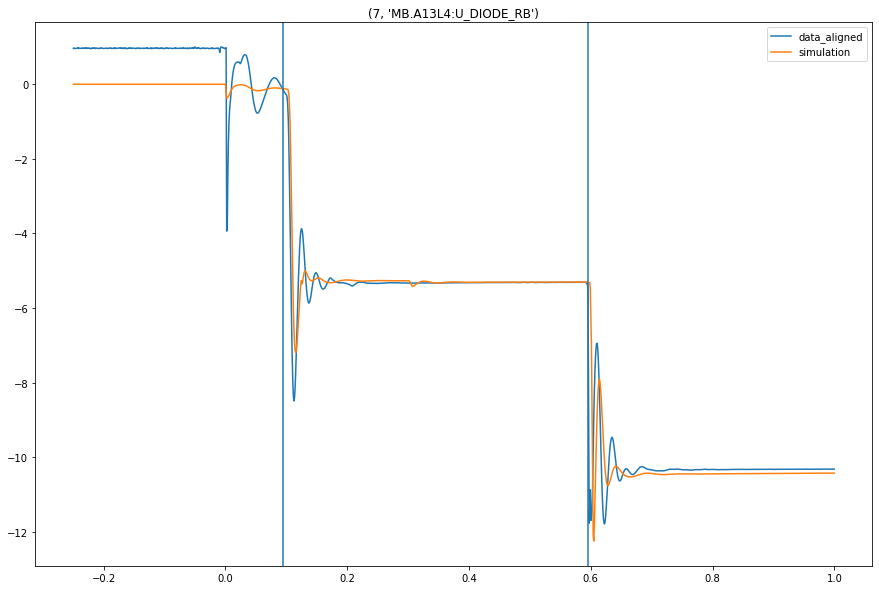

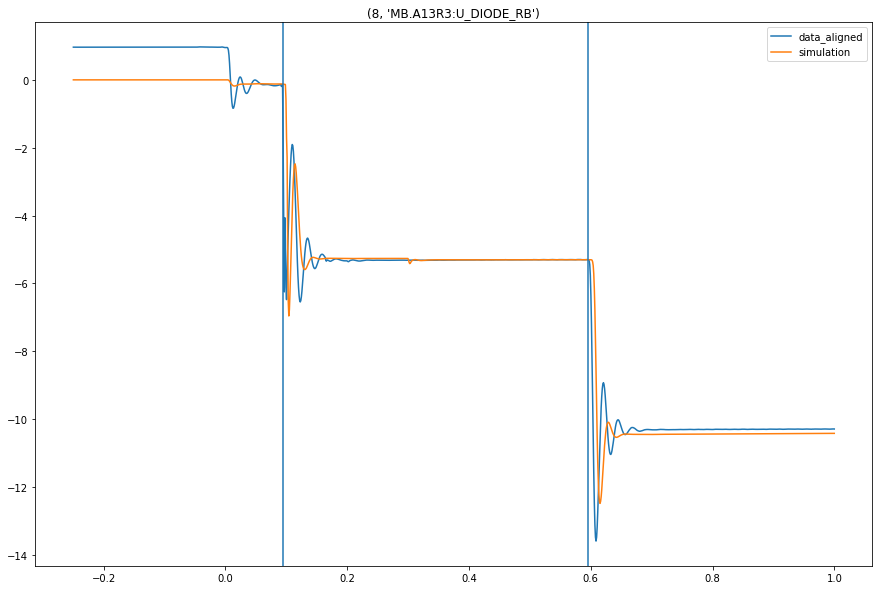

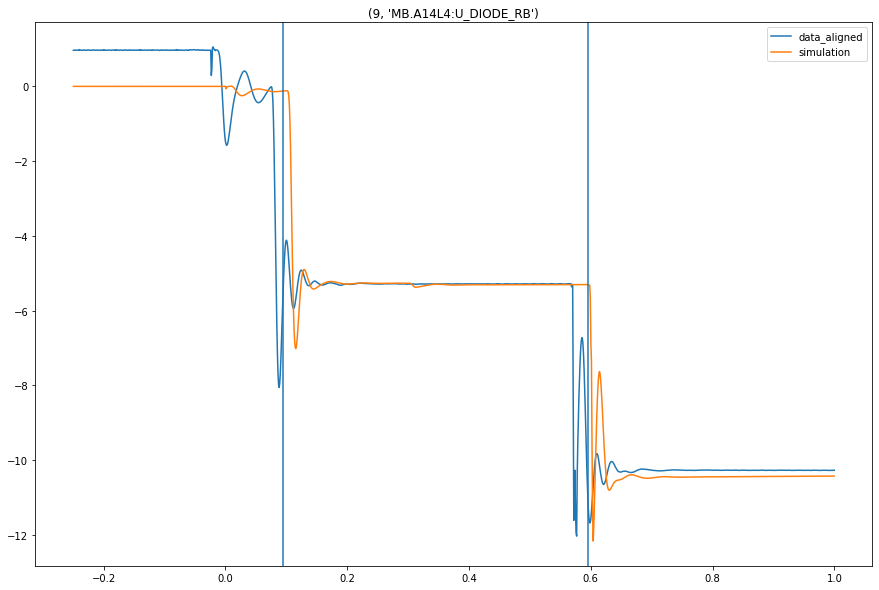

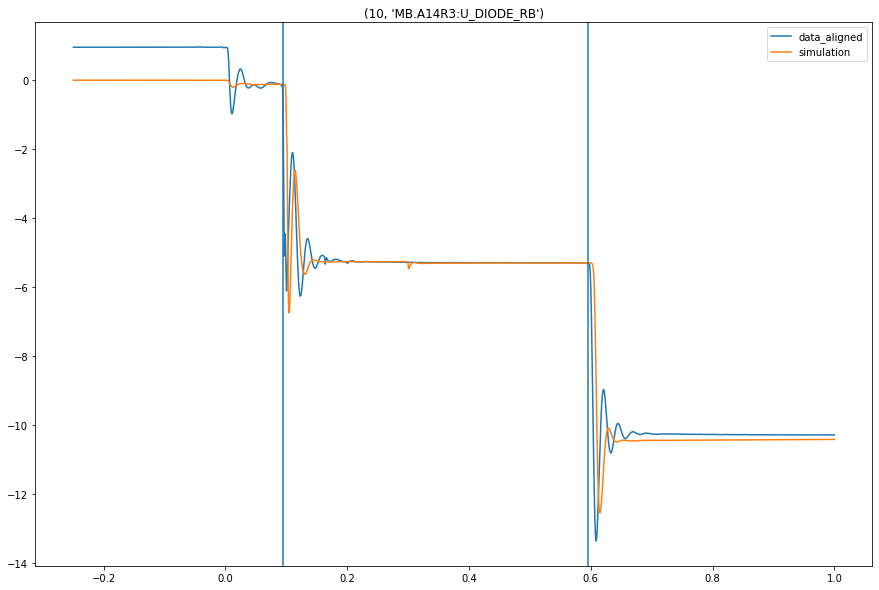

In [17]:
i =1
for c in df_data_aligned.columns:
    fig, ax = plt.subplots(figsize = (15,10))
    df_data_cut[c].plot(ax=ax, label="data_aligned")
    #df_data_noq[c].plot(ax=ax, label="data")
    #df_data_aligned
    df_sim_noq_resampled[c].plot(ax=ax, label="simulation")
    plt.title(f"{i,c}")
    plt.legend()
    
    ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
    ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000
    plt.axvline(x=ee_odd)
    plt.axvline(x=ee_even)

    i+=1
    if i > 10:
        break

# Align all events

In [ ]:
faulty_sim_events = ["RB_RB.A45_1619677558420000000","RB_RB.A34_1619762968760000000"]

In [37]:
i =1
dataset = []
for k, row in df_to_analyze.iterrows():
    circuit_name = row['Circuit Name']
    timestamp_fgc = int(row['timestamp_fgc'])
    fpa_identifier = f"{row['Circuit Family']}_{row['Circuit Name']}_{int(row['timestamp_fgc'])}"
    
    mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == row['timestamp_fgc']) & 
                                   (mp3_fpa_df['Circuit Name'] == row['Circuit Name'])]
    all_quenched_magnets = mp3_fpa_df_subset.Position.values
    quench_times = mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3
    
    # load simulation 
    simulation_dir = simulation_path / (fpa_identifier + ".hdf")
    plot_dir = data_path.parent / f"20220707_udiode_aligned_plots_nosim/{fpa_identifier}.png"
    
        if os.path.isfile(simulation_dir) and not os.path.isfile(plot_dir):# and not (fpa_identifier in faulty_events):
            data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
            df_sim = u_diode_simulation_to_df(data_sim, circuit_name=circuit_name)

                # load data
            data_dir = data_path / (fpa_identifier + ".hdf5")
            data = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
            df_data = u_diode_data_to_df(data, len_data=len(data[0]))

            # load simulation 
            simulation_dir = simulation_path / (fpa_identifier + ".hdf")
            data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
            df_sim = u_diode_simulation_to_df(data_sim, circuit_name=circuit_name)

            # save magnet order for later useage
            magnet_list=df_sim.columns

            # drop quenched magnet
            max_time = df_data.index.max()
            df_data_noq = drop_quenched_magnets(df_data, all_quenched_magnets, quench_times, max_time)
            df_sim_noq = drop_quenched_magnets(df_sim, all_quenched_magnets, quench_times, max_time)

            # sometimes only noise is stored, mean must be in windwo -1, -10
            df_data_noq = df_data_noq.drop(df_data_noq.columns[~(-1>df_data_noq.mean()) & (-10<df_data_noq.mean())], axis=1)

            # align 
            t_first_extraction = min(float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000, 
                                     float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000)
            df_data_aligned = align_u_diode_data_to_simulation(df_data_noq.copy(), t_first_extraction)

            # cut out time frame to analyze, [-0.25, 1] is 1336 samples
            time_frame = [-0.25, 1]
            df_data_cut = df_data_aligned[(time_frame[0] <= df_data_aligned.index) & (time_frame[1] >= df_data_aligned.index)]

            # adjust simulation length to data 
            df_sim_noq_resampled = interp(df_sim_noq, df_data_cut.index)

            # add quenched magnets again for continuity
            dropped_columns_data = magnet_list[~magnet_list.isin(df_data_cut.columns)]
            dropped_columns_simulation = magnet_list[~magnet_list.isin(df_sim_noq_resampled.columns)]
            df_data_cut[dropped_columns_data] = np.nan
            df_sim_noq_resampled[dropped_columns_simulation] = np.nan
            # bring into electrical order again
            df_data_cut = df_data_cut[magnet_list]
            df_sim_noq_resampled = df_sim_noq_resampled[magnet_list]

            # add data and simulation
            xr_array = data_to_xarray(df_data=df_data_cut, df_simulation=df_sim_noq_resampled, event_identifier=fpa_identifier)
            dataset.append(xr_array)
            
            fig, ax = plt.subplots(2,1, figsize = (15,10))
            df_data_cut.plot(legend=False, ax=ax[0])
            ax[0].set_title("data")
            ax[0].axvline(x=t_first_extraction)

            df_sim_noq_resampled.plot(legend=False, ax=ax[1])
            ax[1].set_title("simulation")
            plt.setp(ax, ylim=ax[0].get_ylim(), xlim=ax[0].get_xlim())
            plt.tight_layout()
            
            print(len(df_sim_noq_resampled))

            plt.savefig(plot_dir)
            plt.close(fig)
            
xr.concat(dataset, dim="event")

1336
1336
1336
1336
1336
1336
1336
1336
1336
1336
1336
1336
1336
1336
1336
1336
1336
1336
1336


KeyboardInterrupt: 